In [1]:
import numpy as np
from matplotlib import pyplot as plt
import py_gauge_mc
from tqdm import tqdm

In [2]:
replicas = 128
staging = 8
v_n = 64
L = 8
lf = py_gauge_mc.WindingNumberLeapfrog(replicas + staging, v_n, L,L,L,L)
lf.set_use_heatbath(True)

potentials_form = np.array([x**2 for x in range(0,v_n)], dtype=np.float32)

num_steps = 16
inv_ks = np.linspace(0.1,1.0,num_steps*(replicas - 1) + 1, dtype=np.float32)

In [3]:
all_inv_ks = []
all_ws = []
all_es = []

windings = None
counts = None
for i in tqdm(range(num_steps)):
    sub_inv_ks = inv_ks[i*(replicas - 1):i*(replicas - 1) + replicas]
    potentials = np.einsum('i,j->ij', sub_inv_ks, potentials_form)
    lf.init_potentials(potentials, windings=windings, standarize=True, num_staging=staging)
    w, e = lf.repeated_seed_and_measure(100, 10, 10, 10, 10)
    windings = w[-1,:,:]
    all_inv_ks.append(sub_inv_ks)
    all_ws.append(w)
    all_es.append(e)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 16/16 [35:11<00:00, 131.97s/it]


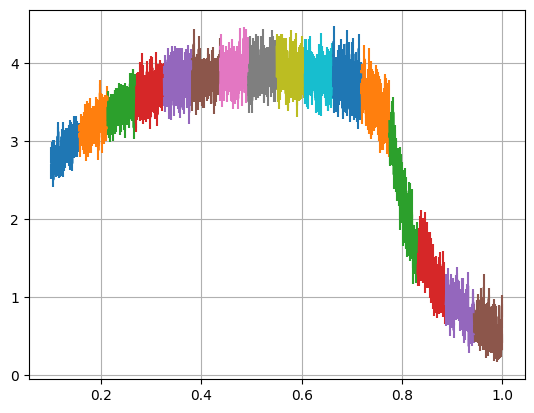

In [13]:
for ik, e in zip(all_inv_ks, all_es):
    plt.errorbar(ik, e.mean(axis=0), yerr=e.std(axis=0)/np.sqrt(e.shape[0]))
plt.grid()
plt.show()

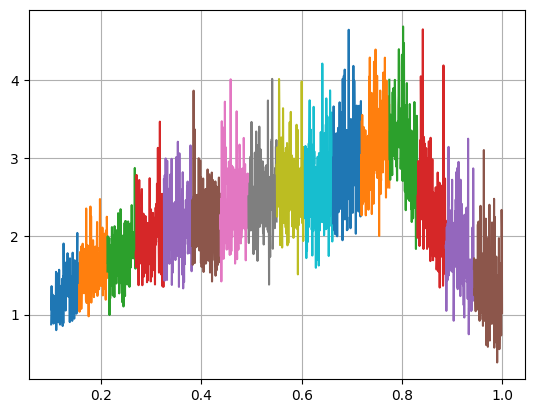

In [15]:
for ik, e in zip(all_inv_ks, all_es):
    plt.plot(ik, e.var(axis=0))
plt.grid()
plt.show()

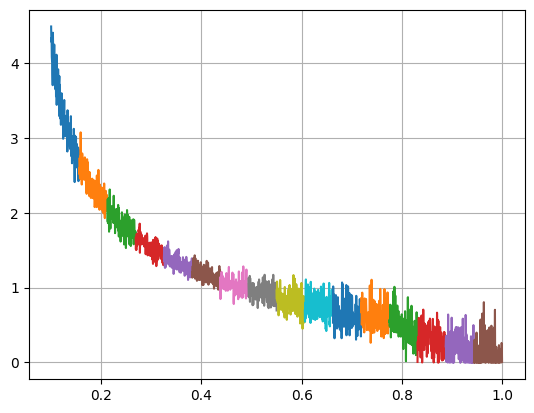

In [14]:
for ik, w in zip(all_inv_ks, all_ws):
    plt.plot(ik, w.var(axis=(-1,-3)))
plt.grid()
plt.show()